# Eval 7: Mechanism of Action Matching

**Biological question**: Do perturbations targeting genes in the same pathway produce similar predicted expression changes?

**Use Case**: MoA Inference - if this works, we can match unknown perturbations to known mechanisms by comparing their predicted effects.

**Setup**: For each perturbation, compute predicted expression delta. Group by target gene's pathway. Compare within-pathway vs between-pathway similarity.

**Metrics**: Within/between pathway similarity ratio, statistical significance

## Setup

In [1]:
import sys
sys.path.insert(0, '..')

import torch
import numpy as np
import json
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.stats import mannwhitneyu
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

from eval_common import EvalContext, update_eval_report
from pathway_utils import load_pathway_annotations

In [2]:
ctx = EvalContext()
inference = ctx.run_test_inference()

using cpu
Input Bank (DNA): torch.Size([1250, 1536])
<All keys matched successfully>
Decoder loaded
found 4 shards for split test
loading /Users/djemec/data/jepa/v0_4/training/test/shard_k562e_test_0002.npz


Running inference:  26%|███████▋                      | 312/1213 [02:40<07:12,  2.08it/s]

loading /Users/djemec/data/jepa/v0_4/training/test/shard_k562e_test_0003.npz


Running inference:  48%|██████████████▌               | 588/1213 [04:44<03:57,  2.63it/s]

loading /Users/djemec/data/jepa/v0_4/training/test/shard_k562e_test_0001.npz


Running inference:  74%|██████████████████████▎       | 900/1213 [06:41<02:05,  2.49it/s]

loading /Users/djemec/data/jepa/v0_4/training/test/shard_k562e_test_0000.npz


Running inference: 100%|█████████████████████████████| 1213/1213 [08:35<00:00,  2.35it/s]


Aggregated 286 perturbations, 38816 samples


## Load Pathway Annotations

In [3]:
pathway_libs = load_pathway_annotations(['KEGG_2021_Human'])

Loading KEGG_2021_Human...
  320 pathways loaded


In [4]:
with open(ctx.paths['pert_dir'] / 'input_to_id.json') as f:
    input_to_id = json.load(f)

id_to_gene = {}
for pert_key, pert_id in input_to_id.items():
    gene_name = pert_key.split('_')[0].upper()
    id_to_gene[pert_id] = gene_name

print(f'Loaded {len(id_to_gene)} perturbation -> gene mappings')

Loaded 1250 perturbation -> gene mappings


In [5]:
MIN_PATHWAY_SIZE, MAX_PATHWAY_SIZE = 15, 200

gene_to_pathway = {}
for pathway, genes in pathway_libs['KEGG_2021_Human'].items():
    if MIN_PATHWAY_SIZE <= len(genes) <= MAX_PATHWAY_SIZE:
        for gene in genes:
            if gene.upper() not in gene_to_pathway:
                gene_to_pathway[gene.upper()] = pathway

pert_to_pathway = {}
for pert_id, gene in id_to_gene.items():
    if gene in gene_to_pathway:
        pert_to_pathway[pert_id] = gene_to_pathway[gene]

print(f'Perturbations with pathway labels: {len(pert_to_pathway)}')
print(f'Unique pathways: {len(set(pert_to_pathway.values()))}')

Perturbations with pathway labels: 623
Unique pathways: 86


## Compute Predicted Deltas by Perturbation

Use the mean predicted delta for each perturbation (averaged across test samples).

In [6]:
test_pert_ids = set(inference['pert_ids'])
valid_perts = [pid for pid in pert_to_pathway.keys() if pid in test_pert_ids]
print(f'Perturbations in test set with pathway labels: {len(valid_perts)}')

pathway_to_perts = defaultdict(list)
for pid in valid_perts:
    pathway_to_perts[pert_to_pathway[pid]].append(pid)

MIN_PERTS_PER_PATHWAY = 3
valid_pathways = {p: perts for p, perts in pathway_to_perts.items() if len(perts) >= MIN_PERTS_PER_PATHWAY}
print(f'Pathways with >= {MIN_PERTS_PER_PATHWAY} perturbations: {len(valid_pathways)}')

Perturbations in test set with pathway labels: 149
Pathways with >= 3 perturbations: 13


In [7]:
all_perts_in_valid = [pid for perts in valid_pathways.values() for pid in perts]
pert_id_to_idx = {pid: i for i, pid in enumerate(all_perts_in_valid)}

delta_matrix = np.zeros((len(all_perts_in_valid), ctx.config['n_genes']))
for i, pid in enumerate(all_perts_in_valid):
    delta_matrix[i] = inference['mean_pred_deltas'][pid]

print(f'Delta matrix shape: {delta_matrix.shape}')

Delta matrix shape: (116, 5000)


## Compute Within vs Between Pathway Similarity

In [8]:
sim_matrix = cosine_similarity(delta_matrix)
print(f'Similarity matrix shape: {sim_matrix.shape}')

Similarity matrix shape: (116, 116)


In [9]:
within_sims = []
between_sims = []

for pathway, perts in valid_pathways.items():
    indices = [pert_id_to_idx[pid] for pid in perts]
    
    for i, idx_i in enumerate(indices):
        for j, idx_j in enumerate(indices):
            if i < j:
                within_sims.append(sim_matrix[idx_i, idx_j])

pathway_list = list(valid_pathways.keys())
for i, p1 in enumerate(pathway_list):
    for j, p2 in enumerate(pathway_list):
        if i < j:
            for pid1 in valid_pathways[p1]:
                for pid2 in valid_pathways[p2]:
                    idx1, idx2 = pert_id_to_idx[pid1], pert_id_to_idx[pid2]
                    between_sims.append(sim_matrix[idx1, idx2])

within_sims = np.array(within_sims)
between_sims = np.array(between_sims)

print(f'Within-pathway pairs: {len(within_sims)}')
print(f'Between-pathway pairs: {len(between_sims)}')

Within-pathway pairs: 771
Between-pathway pairs: 5899


In [10]:
mean_within = np.mean(within_sims)
mean_between = np.mean(between_sims)
similarity_ratio = mean_within / mean_between if mean_between != 0 else float('inf')

stat, p_value = mannwhitneyu(within_sims, between_sims, alternative='greater')

print(f'Mean within-pathway similarity:  {mean_within:.4f}')
print(f'Mean between-pathway similarity: {mean_between:.4f}')
print(f'Similarity ratio: {similarity_ratio:.3f}x')
print(f'Mann-Whitney U p-value: {p_value:.2e}')

Mean within-pathway similarity:  0.9088
Mean between-pathway similarity: 0.9055
Similarity ratio: 1.004x
Mann-Whitney U p-value: 5.09e-03


## Visualization

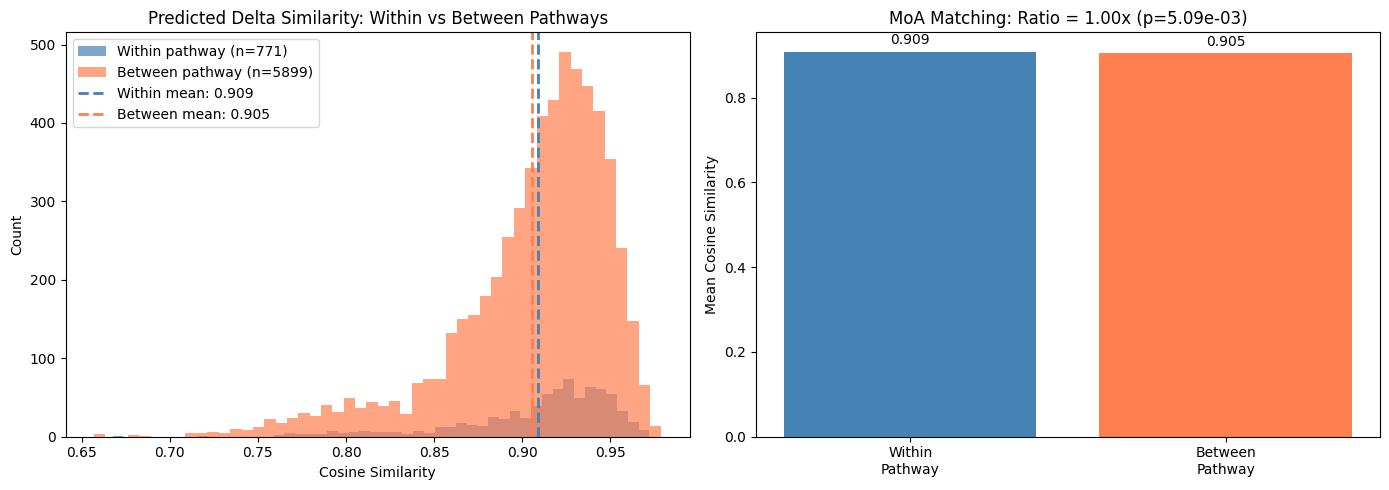

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(within_sims, bins=50, alpha=0.7, label=f'Within pathway (n={len(within_sims)})', color='steelblue')
axes[0].hist(between_sims, bins=50, alpha=0.7, label=f'Between pathway (n={len(between_sims)})', color='coral')
axes[0].axvline(mean_within, color='steelblue', linestyle='--', linewidth=2, label=f'Within mean: {mean_within:.3f}')
axes[0].axvline(mean_between, color='coral', linestyle='--', linewidth=2, label=f'Between mean: {mean_between:.3f}')
axes[0].set_xlabel('Cosine Similarity')
axes[0].set_ylabel('Count')
axes[0].set_title('Predicted Delta Similarity: Within vs Between Pathways')
axes[0].legend()

labels = ['Within\nPathway', 'Between\nPathway']
means = [mean_within, mean_between]
colors = ['steelblue', 'coral']
bars = axes[1].bar(labels, means, color=colors)
axes[1].set_ylabel('Mean Cosine Similarity')
axes[1].set_title(f'MoA Matching: Ratio = {similarity_ratio:.2f}x (p={p_value:.2e})')
for bar, val in zip(bars, means):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{val:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Per-Pathway Breakdown

In [12]:
pathway_stats = []
for pathway, perts in valid_pathways.items():
    indices = [pert_id_to_idx[pid] for pid in perts]
    if len(indices) >= 2:
        within = [sim_matrix[i, j] for i in indices for j in indices if i < j]
        if within:
            pathway_stats.append((pathway[:40], len(perts), np.mean(within)))

pathway_stats.sort(key=lambda x: -x[2])

print('Top 10 pathways by within-pathway similarity:')
print(f'{"Pathway":<42} {"N perts":>8} {"Mean sim":>10}')
print('-' * 62)
for name, n, sim in pathway_stats[:10]:
    print(f'{name:<42} {n:>8} {sim:>10.4f}')

Top 10 pathways by within-pathway similarity:
Pathway                                     N perts   Mean sim
--------------------------------------------------------------
Ribosome                                         21     0.9336
mRNA surveillance pathway                         8     0.9274
DNA replication                                   3     0.9246
N-Glycan biosynthesis                             3     0.9176
Cell cycle                                        5     0.9142
Spliceosome                                      25     0.9034
RNA degradation                                   3     0.9013
RNA transport                                    11     0.8993
Protein export                                    4     0.8950
Cytosolic DNA-sensing pathway                     7     0.8876


---
## Summary

In [13]:
print('='*70)
print('EVAL 7: MECHANISM OF ACTION MATCHING - RESULTS')
print('='*70)
print()
print('CONFIGURATION')
print(f'  Pathways analyzed: {len(valid_pathways)}')
print(f'  Perturbations: {len(all_perts_in_valid)}')
print(f'  Within-pathway pairs: {len(within_sims)}')
print(f'  Between-pathway pairs: {len(between_sims)}')
print()
print('RESULTS')
print(f'  Mean within-pathway similarity:  {mean_within:.4f}')
print(f'  Mean between-pathway similarity: {mean_between:.4f}')
print(f'  Similarity ratio: {similarity_ratio:.3f}x')
print(f'  Mann-Whitney U p-value: {p_value:.2e}')
print()
print('INTERPRETATION')
print('-'*40)
if similarity_ratio > 1.2 and p_value < 0.05:
    print('GOOD: Same-pathway perturbations produce more similar predicted effects.')
    print('This suggests the model captures mechanistic relationships.')
elif similarity_ratio > 1.0:
    print('WEAK: Slight trend toward pathway-based similarity, but not strong.')
else:
    print('NO SIGNAL: Within and between pathway similarities are similar.')

EVAL 7: MECHANISM OF ACTION MATCHING - RESULTS

CONFIGURATION
  Pathways analyzed: 13
  Perturbations: 116
  Within-pathway pairs: 771
  Between-pathway pairs: 5899

RESULTS
  Mean within-pathway similarity:  0.9088
  Mean between-pathway similarity: 0.9055
  Similarity ratio: 1.004x
  Mann-Whitney U p-value: 5.09e-03

INTERPRETATION
----------------------------------------
WEAK: Slight trend toward pathway-based similarity, but not strong.


In [14]:
update_eval_report('eval_7_moa_matching', {
    'config': {
        'n_pathways': len(valid_pathways),
        'n_perturbations': len(all_perts_in_valid),
        'min_perts_per_pathway': MIN_PERTS_PER_PATHWAY,
        'pathway_size_range': [MIN_PATHWAY_SIZE, MAX_PATHWAY_SIZE]
    },
    'similarity': {
        'mean_within_pathway': float(mean_within),
        'mean_between_pathway': float(mean_between),
        'similarity_ratio': float(similarity_ratio),
        'mann_whitney_p': float(p_value),
        'n_within_pairs': len(within_sims),
        'n_between_pairs': len(between_sims)
    }
})

Updated eval_report.json
